# Macaque CT-model's Experiment

In [1]:
import os
import numpy as np
import matplotlib.pylab as plt
from matplotlib import gridspec
os.chdir('../')
from src.data_loading import LoadCSV, LoadCSVandVIDEO
from src.data_preprocessing.video import rotate_video, crop_video_depend_scanposition, downsample_video

In [2]:
rcParams_dict = {
    'font.family':'Times New Roman',
    'mathtext.fontset':'stix',
    'font.size':15,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'axes.linewidth':1.5,
    'xtick.major.size':8,
    'ytick.major.size':8,}
for key in rcParams_dict.keys():plt.rcParams[str(key)] = rcParams_dict[str(key)]

In [3]:
### DEFINE
CSV_DIR = './data/macaque_ctmodel/CSV/'
AVI_DIR = './data/macaque_ctmodel/AVI/'
DATA_NAME = 'vf10_1_4'
SAMPLE_SPAN = [60000, 70010]
LINESCAN_PARAM = {'position':[128, 60], 'width':100}
ROTATE_ANGLE = -90
DOWNSAMPLE_FACTOR = 1
FLOW_RATE = 40

In [4]:
### Load data
[flow_all, mic_all, mic_t_all] = LoadCSV(CSV_DIR+DATA_NAME+".csv", ["FLOW", "MIC", "T"], [0, None])
[mic, mic_t], video, video_t = LoadCSVandVIDEO(CSV_DIR+DATA_NAME+".csv", ["MIC", "T"], SAMPLE_SPAN, AVI_DIR+DATA_NAME+".avi")
### Preprocess
flow_all *= FLOW_RATE
video = rotate_video(video[:video.shape[0]//2], ROTATE_ANGLE)
video = crop_video_depend_scanposition(video, LINESCAN_PARAM)
video = downsample_video(video, DOWNSAMPLE_FACTOR)

Loading csv data
file path | ./data/macaque_ctmodel/CSV/vf10_1_4.csv
data list | FLOW, MIC, T
Loading csv data
file path | ./data/macaque_ctmodel/CSV/vf10_1_4.csv
data list | MIC, T
Loading video data
file path | ./data/macaque_ctmodel/AVI/vf10_1_4.avi


In [5]:
from src.util import fft, short_time_ft

def flow_timeseries_spectrogram(time, flow, mic,sample_span, 
                                stfft_params={'nperseg': 2000, 'cmap_lim': (-150, -30), 'freq_lim': (0, 700), 'cmap': 'jet'},):    
    spec = gridspec.GridSpec(ncols=2, nrows=3, width_ratios=[1, 0.04], height_ratios=[1, 1, 1], wspace=0, hspace=0.55)
    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(spec[0])
    ax.set_title('Flow rate signal', loc='left', fontsize=plt.rcParams['font.size'])
    ax.plot(time, flow, c='k', lw=1)
    ax.set_ylabel(r'$\mu$ [L/min]')
    ax.get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax.get_yaxis().set_major_formatter(plt.FormatStrFormatter('%d'))
    ax.set_xlim(time[0], time[-1])
    ax.axvline(x=time[sample_span[0]], linestyle='--', c='b', lw=1)
    ax.axvline(x=time[sample_span[-1]], linestyle='--', c='b', lw=1)

    ax = fig.add_subplot(spec[2])
    ax.set_title('Microphone signal', loc='left', fontsize=plt.rcParams['font.size'])
    ax.plot(time, mic, c='k', lw=1)
    ax.set_ylabel(r'$x(t)$ [V]')
    ax.get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax.get_yaxis().set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax.set_xlim(time[0], time[-1])
    ax.axvline(x=time[sample_span[0]], linestyle='--', c='b', lw=1)
    ax.axvline(x=time[sample_span[-1]], linestyle='--', c='b', lw=1)

    ax = fig.add_subplot(spec[4])
    ax.set_title('Spectrogram of the microphone signal', loc='left', fontsize=plt.rcParams['font.size'])
    dt = time[1] - time[0]
    freq, t_stft, intens = short_time_ft(mic, dt, stfft_params['nperseg'])
    p = np.linspace(time[0], time[-1], t_stft.shape[0])
    power = 10*np.log(np.abs(intens))
    img = ax.pcolormesh(p, freq, power, cmap=stfft_params['cmap'], vmin=stfft_params['cmap_lim'][0], vmax=stfft_params['cmap_lim'][1])
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(stfft_params['freq_lim'])
    ax.set_xlabel(r'Time $t$ [s]')
    ax.set_ylabel(r'Frequency [Hz]')
    ax.get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax.get_yaxis().set_major_formatter(plt.FormatStrFormatter('%d'))
    ax.axvline(x=time[sample_span[0]], linestyle='--', c='b', lw=1)
    ax.axvline(x=time[sample_span[-1]], linestyle='--', c='b', lw=1)
    
    ax = fig.add_subplot(spec[5])
    ax.axis("off")
    fig.colorbar(img, location='right', ax=ax, shrink=10)

    plt.show()

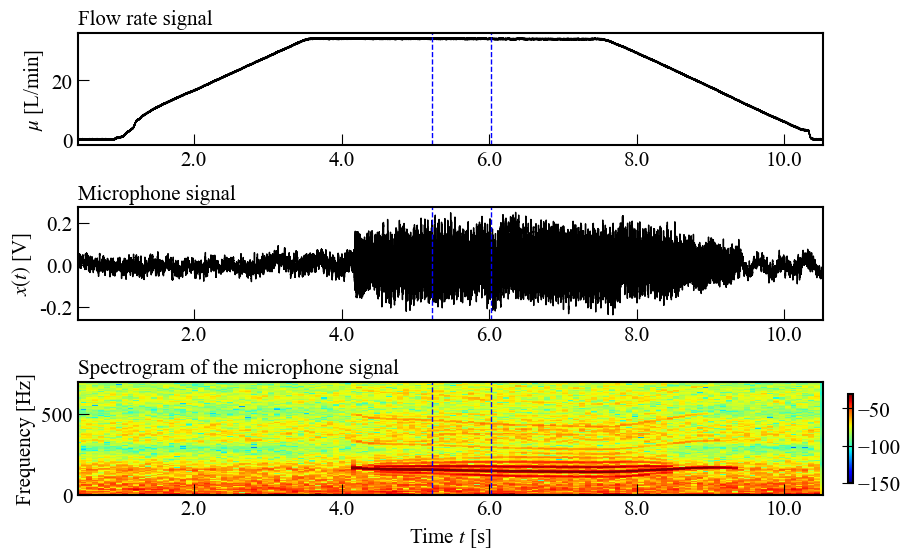

In [6]:
flow_timeseries_spectrogram(mic_t_all, flow_all, mic_all, SAMPLE_SPAN)

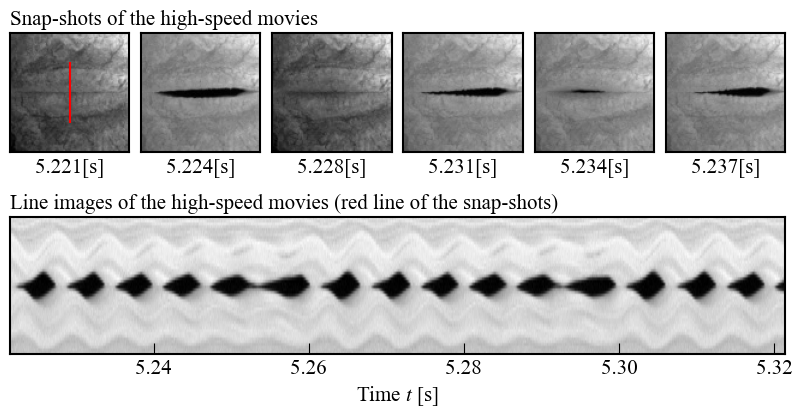

In [19]:
def images_kymogram(video, video_t, linescan_params, n_plt=3000, step=10, start_time_0=False, time_format='{:.2f}'):

    if start_time_0: video_t -= video_t[0]
    t_min = video_t[0]
    t_max = video_t[n_plt - 1] if n_plt <= len(video_t) else video_t[-1]
    position = linescan_params['position']
    width = linescan_params['width']
    kymogram = video[:, (position[0]-int(width/2)):(position[0]+int(width/2)), position[1]]
    y = np.arange(position[0]-int(width/2), position[0]+int(width/2))
    x = np.full(y.shape[0], position[1])
    aspect = n_plt / kymogram.shape[1] * 0.000018

    spec = gridspec.GridSpec(ncols=6, nrows=2, wspace=0.1, hspace=0.0, height_ratios=[1, 1])
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(spec[0])
    idx = step*0
    ax.set_title('Snap-shots of the high-speed movies', loc='left', fontsize=plt.rcParams['font.size'])
    ax.imshow(video[idx], cmap='gray')
    ax.plot(x, y, c='r')
    ax.set_xlabel(str(time_format.format(video_t[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    ax = fig.add_subplot(spec[1])
    idx = step*1
    ax.imshow(video[idx], cmap='gray')
    ax.set_xlabel(str(time_format.format(video_t[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    ax = fig.add_subplot(spec[2])
    idx = step*2
    ax.imshow(video[idx], cmap='gray')
    ax.set_xlabel(str(time_format.format(video_t[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    ax = fig.add_subplot(spec[3])
    idx = step*3
    ax.imshow(video[idx], cmap='gray')
    ax.set_xlabel(str(time_format.format(video_t[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    ax = fig.add_subplot(spec[4])
    idx = step*4
    ax.imshow(video[idx], cmap='gray')
    ax.set_xlabel(str(time_format.format(video_t[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    ax = fig.add_subplot(spec[5])
    idx = step*5
    ax.imshow(video[idx], cmap='gray')
    ax.set_xlabel(str(time_format.format(video_t[idx]))+r'[s]')
    ax.tick_params(bottom=False, left=False, right=False, top=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    ax = fig.add_subplot(spec[6:12])
    ax.set_title('Line images of the high-speed movies (red line of the snap-shots)', loc='left', fontsize=plt.rcParams['font.size'])
    #ax.pcolormesh(time[:n_plt], np.arange(kymogram.shape[1]), kymogram[:n_plt].T, cmap='gray')
    ax.imshow(kymogram[:n_plt].T, cmap='gray', aspect=aspect,
              extent=[t_min, t_max, 1, kymogram.shape[1]], 
              vmax=np.max(kymogram[:n_plt]), vmin=np.min(kymogram[:n_plt]))
    #ax.invert_yaxis()
    ax.tick_params(labelleft=False, left=False)
    ax.set_xlabel(r'Time $t$ [s]')

    #if self.save: plt.savefig(self.dir+self.name+'_images_kymogram.'+self.ext, bbox_inches="tight") 
    plt.show()

images_kymogram(video, video_t, 
                {'position':[video.shape[1]//2, video.shape[1]//2], 'width':video.shape[1]//2}, 
                n_plt=1000, step=30, start_time_0=False, time_format='{:.3f}')